In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Read data

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")

In [4]:
df.head()

,Date,DayOfWeek,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,IsDayAfterHoliday,temp_max,temp_min,temp_mean,humidity_max,humidity_min,NUMBER_INT,CO,MP10,O3,MP2.5,SO2
0,2015-01-01,Thu,3,1,1,0,1,0,33.9,20.6,25.912500,89.0,32.0,30,0.0,NaN,68.0,NaN,82.0
1,2015-01-02,Fri,4,1,1,0,0,1,32.9,21.0,26.050000,87.0,38.0,43,0.0,NaN,79.0,NaN,83.0
2,2015-01-03,Sat,5,1,1,1,0,0,33.5,20.2,26.683333,83.0,38.0,23,0.0,NaN,44.0,NaN,83.0
3,2015-01-04,Sun,6,1,1,1,0,0,30.6,22.2,25.641667,81.0,43.0,20,0.0,NaN,49.0,NaN,82.0
4,2015-01-05,Mon,0,2,1,0,0,0,30.8,20.8,25.520833,79.0,36.0,51,0.0,NaN,59.0,NaN,82.0


In [5]:
df.count()

Date                 1826
DayOfWeek            1826
DayOfWeekNum         1826
WeekOfYear           1826
Month                1826
IsWeekend            1826
IsHoliday            1826
IsDayAfterHoliday    1826
temp_max             1826
temp_min             1826
temp_mean            1826
humidity_max         1826
humidity_min         1826
NUMBER_INT           1826
CO                   1581
MP10                 1457
O3                   1265
MP2.5                1195
SO2                  1091
dtype: int64

### Set features

In [6]:
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    # 'SO2',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()

In [7]:
# add lag
# df_final['SO2_lag1'] = df_final['SO2'].shift(1)
# df_final['SO2_lag2'] = df_final['SO2'].shift(2)
# df_final['SO2_lag3'] = df_final['SO2'].shift(3)

# df_final['temp_min_lag1'] = df_final['temp_min'].shift(1)
# df_final['temp_min_lag2'] = df_final['temp_min'].shift(2)
# df_final['temp_min_lag3'] = df_final['temp_min'].shift(3)

# df_final['humidity_max_lag1'] = df_final['humidity_max'].shift(1)
# df_final['humidity_max_lag2'] = df_final['humidity_max'].shift(2)
# df_final['humidity_max_lag3'] = df_final['humidity_max'].shift(3)

In [8]:
df_final = df_final.dropna()

In [9]:
# Check non-null counts and data types
df_final.info()

# Check descriptive statistics
df_final.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1826 non-null   object 
 1   DayOfWeekNum  1826 non-null   int64  
 2   WeekOfYear    1826 non-null   int64  
 3   Month         1826 non-null   int64  
 4   IsWeekend     1826 non-null   int64  
 5   IsHoliday     1826 non-null   int64  
 6   NUMBER_INT    1826 non-null   int64  
 7   temp_max      1826 non-null   float64
 8   temp_min      1826 non-null   float64
 9   humidity_max  1826 non-null   float64
dtypes: float64(3), int64(6), object(1)
memory usage: 142.8+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,1826,1826,2019-12-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekNum,1826.0,NaN,NaN,NaN,3.000548,2.000959,0.0,1.0,3.0,5.0,6.0
WeekOfYear,1826.0,NaN,NaN,NaN,26.615553,15.065085,1.0,14.0,27.0,40.0,53.0
Month,1826.0,NaN,NaN,NaN,6.523549,3.449478,1.0,4.0,7.0,10.0,12.0
IsWeekend,1826.0,NaN,NaN,NaN,0.285871,0.451952,0.0,0.0,0.0,1.0,1.0
IsHoliday,1826.0,NaN,NaN,NaN,0.024644,0.15508,0.0,0.0,0.0,0.0,1.0
NUMBER_INT,1826.0,NaN,NaN,NaN,47.780394,15.631632,11.0,37.0,47.0,59.0,94.0
temp_max,1826.0,NaN,NaN,NaN,28.314513,3.044044,17.8,26.3,28.5,30.475,37.7
temp_min,1826.0,NaN,NaN,NaN,17.791347,2.625865,7.3,16.1,18.4,19.7,24.1
humidity_max,1826.0,NaN,NaN,NaN,82.264513,9.226503,42.0,77.0,84.0,90.0,94.0


In [10]:
df_final.dtypes

Date             object
DayOfWeekNum      int64
WeekOfYear        int64
Month             int64
IsWeekend         int64
IsHoliday         int64
NUMBER_INT        int64
temp_max        float64
temp_min        float64
humidity_max    float64
dtype: object

## Train

In [11]:
df_final['Date'] = pd.to_datetime(df_final['Date'])
# df_final = df_final.sort_values(by='Date')

# remove the last 5 days (account for lag ...)
df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)



df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

In [12]:
df_train.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max
0,3,1,1,0,1,30,33.9,20.6,89.0
1,4,1,1,0,0,43,32.9,21.0,87.0
2,5,1,1,1,0,23,33.5,20.2,83.0
3,6,1,1,1,0,20,30.6,22.2,81.0
4,0,2,1,0,0,51,30.8,20.8,79.0


In [13]:
df_train.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max
1456,3,52,12,0,0,60,24.8,18.8,92.0
1457,4,52,12,0,0,61,25.4,18.5,92.0
1458,5,52,12,1,0,30,27.5,17.7,92.0
1459,6,52,12,1,0,26,27.3,18.5,93.0
1460,0,1,12,0,0,61,25.9,19.2,92.0


In [14]:
df_val.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max
1461,1,1,1,0,1,44,27.9,19.2,92.0
1462,2,1,1,0,0,45,31.1,18.9,90.0
1463,3,1,1,0,0,28,30.7,20.4,88.0
1464,4,1,1,0,0,37,25.4,19.0,91.0
1465,5,1,1,1,0,36,30.1,18.6,91.0


In [15]:
df_val.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,temp_max,temp_min,humidity_max
1816,6,51,12,1,0,34,32.9,20.3,84.0
1817,0,52,12,0,0,47,25.9,19.0,91.0
1818,1,52,12,0,0,37,24.6,17.6,91.0
1819,2,52,12,0,1,59,30.3,17.4,91.0
1820,3,52,12,0,0,71,30.4,20.8,79.0


## Test (10x with cv)

In [16]:
results = []
results30 = []

param_grid = {
    'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160],
    'max_depth': [2, 4, 6, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [17]:
for i in range(10):
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=i),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nRun {i+1} Best Hyperparameters:")
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Best R-squared: {grid_search.best_score_:.4f}")

    best_xgb_model = grid_search.best_estimator_
    y_pred = best_xgb_model.predict(X_val)

    # Metrics 1y
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    mape_val = mape(y_val, y_pred)
    smape_val = smape(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    corr = np.corrcoef(y_val, y_pred)[0, 1]

    # Metrics 30d
    y_pred_30d = best_xgb_model.predict(X_val[:30])
    y_val_30 = y_val[:30]
    mse_30d = mean_squared_error(y_val_30, y_pred_30d)
    rmse_30d = np.sqrt(mse_30d)
    mae_30d = mean_absolute_error(y_val_30, y_pred_30d)
    mape_val_30d = mape(y_val_30, y_pred_30d)
    smape_val_30d = smape(y_val_30, y_pred_30d)
    r2_30d = r2_score(y_val_30, y_pred_30d)
    corr_30d = np.corrcoef(y_val_30, y_pred_30d)[0, 1]

    results.append({
        'run': i+1,
        'random_state': i,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'R2': r2,
        'Correlation': corr,
        'Best Params': grid_search.best_params_,
        'Best Cross-validated R-squared': grid_search.best_score_
    })

    results30.append({
        'run': i+1,
        'random_state': i,
        'MSE_30d': mse_30d,
        'RMSE_30d': rmse_30d,
        'MAE_30d': mae_30d,
        'MAPE_30d': mape_val_30d,
        'sMAPE_30d': smape_val_30d,
        'R2_30d': r2_30d,
        'Correlation_30d': corr_30d
    })




Run 1 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.5530

Run 2 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.5554

Run 3 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.5542

Run 4 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}
Best R-squared: 0.5531

Run 5 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}
Best R-squared: 0.5560

Run 6 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_es

### Results 1y

In [18]:
results_df = pd.DataFrame(results)
results_df

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Params,Best Cross-validated R-squared
0,1,0,121.872810,11.039602,8.267699,15.636888,16.592384,0.490204,0.780405,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.552968
1,2,1,120.863213,10.993781,8.234096,15.595544,16.557759,0.494427,0.782560,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.555419
2,3,2,121.531227,11.024120,8.249487,15.629237,16.583259,0.491633,0.781115,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.554156
3,4,3,121.876717,11.039779,8.269840,15.655297,16.614425,0.490188,0.780940,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.553083
4,5,4,120.879776,10.994534,8.219547,15.573996,16.524816,0.494358,0.781961,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.556039
5,6,5,121.670815,11.030449,8.244569,15.653204,16.643022,0.491049,0.780060,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.554279
6,7,6,121.168533,11.007658,8.225124,15.565871,16.535232,0.493150,0.781836,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.553594
7,8,7,122.011429,11.045878,8.271369,15.669774,16.626455,0.489624,0.780036,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.553704
8,9,8,121.872810,11.039602,8.267699,15.636888,16.592384,0.490204,0.780405,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.552968
9,10,9,123.025253,11.091675,8.290692,15.711063,16.679665,0.485384,0.777200,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.553381


In [19]:
results_df.describe()

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Cross-validated R-squared
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,121.677258,11.030708,8.254012,15.632776,16.594940,0.491022,0.780652,0.553959
std,3.02765,3.02765,0.634546,0.028741,0.023095,0.044455,0.048163,0.002654,0.001484,0.001047
min,1.00000,0.00000,120.863213,10.993781,8.219547,15.565871,16.524816,0.485384,0.777200,0.552968
25%,3.25000,2.25000,121.259207,11.011774,8.236714,15.603967,16.564134,0.490192,0.780146,0.553157
50%,5.50000,4.50000,121.771812,11.035026,8.258593,15.636888,16.592384,0.490627,0.780673,0.553649
75%,7.75000,6.75000,121.875740,11.039735,8.269305,15.654774,16.623448,0.492771,0.781656,0.554248
max,10.00000,9.00000,123.025253,11.091675,8.290692,15.711063,16.679665,0.494427,0.782560,0.556039


### results 30d

In [20]:
results_df_30 = pd.DataFrame(results30)
results_df_30

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
0,1,0,53.885052,7.340644,6.159060,15.652741,16.931873,0.195225,0.714915
1,2,1,54.966961,7.413971,6.253947,16.090271,17.437557,0.179067,0.715073
2,3,2,54.132641,7.357489,6.185549,15.896198,17.200567,0.191527,0.713513
3,4,3,54.922974,7.411004,6.213461,15.826189,17.119858,0.179724,0.706001
4,5,4,55.365196,7.440779,6.271337,16.021201,17.394444,0.173119,0.718977
5,6,5,57.299454,7.569640,6.359223,16.315175,17.791173,0.144231,0.714215
6,7,6,55.805141,7.470284,6.254510,15.802756,17.135231,0.166548,0.713684
7,8,7,54.151176,7.358748,6.166789,15.742215,17.022721,0.191251,0.709055
8,9,8,53.885052,7.340644,6.159060,15.652741,16.931873,0.195225,0.714915
9,10,9,55.366310,7.440854,6.307963,16.279554,17.625513,0.173102,0.706877


In [21]:
results_df_30.describe()

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,54.977996,7.414406,6.233090,15.927904,17.259081,0.178902,0.712723
std,3.02765,3.02765,1.062727,0.071372,0.068211,0.240746,0.293582,0.015872,0.004094
min,1.00000,0.00000,53.885052,7.340644,6.159060,15.652741,16.931873,0.144231,0.706001
25%,3.25000,2.25000,54.137275,7.357804,6.171479,15.757350,17.047005,0.173107,0.710170
50%,5.50000,4.50000,54.944967,7.412487,6.233704,15.861194,17.167899,0.179395,0.713950
75%,7.75000,6.75000,55.366032,7.440835,6.267130,16.073003,17.426779,0.191458,0.714915
max,10.00000,9.00000,57.299454,7.569640,6.359223,16.315175,17.791173,0.195225,0.718977


## Plots    

In [22]:
best_idx = results_df['RMSE'].idxmin()
print(f"Best run based on RMSE: Run {results_df.loc[best_idx, 'run']} with RMSE = {results_df.loc[best_idx, 'RMSE']:.2f}")

best_params = results_df.loc[best_idx, 'Best Params']
print(f"Best parameters: {best_params}")

best_random_state = results_df.loc[best_idx, 'run'] - 1 

# Rebuild the best model
best_model = XGBRegressor(random_state=best_random_state, **best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)


Best run based on RMSE: Run 2 with RMSE = 10.99
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 1.0}


### 1y

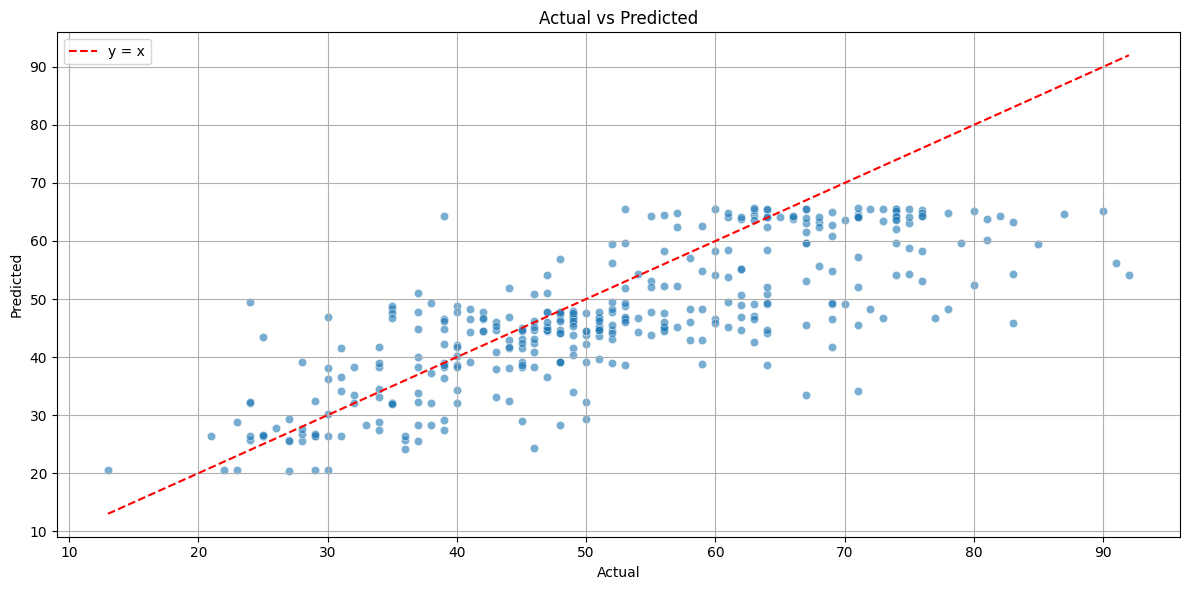

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:], y=y_pred_best, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

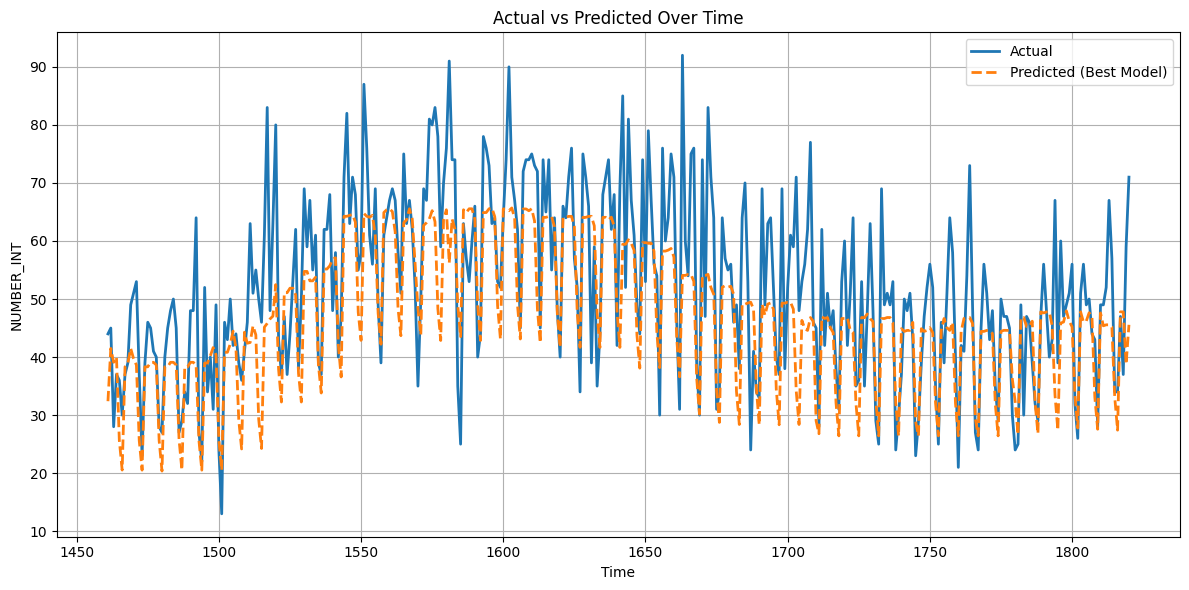

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred_best, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 30d

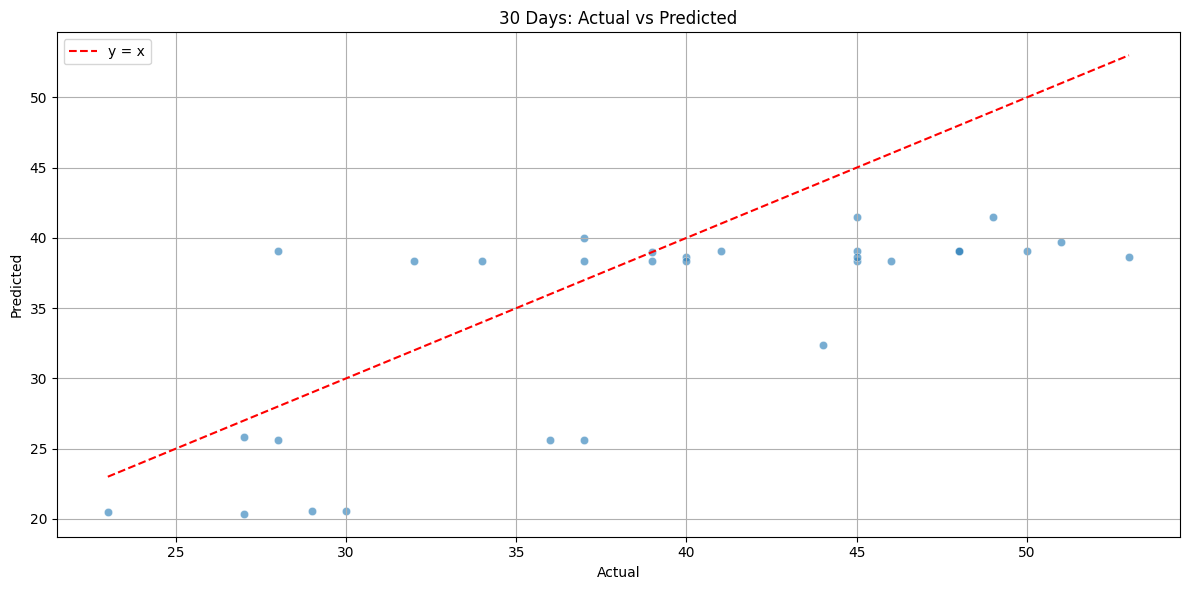

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:30], y=y_pred_best[:30], alpha=0.6)
plt.plot([y_val[:30].min(), y_val[:30].max()], [y_val[:30].min(), y_val[:30].max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('30 Days: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


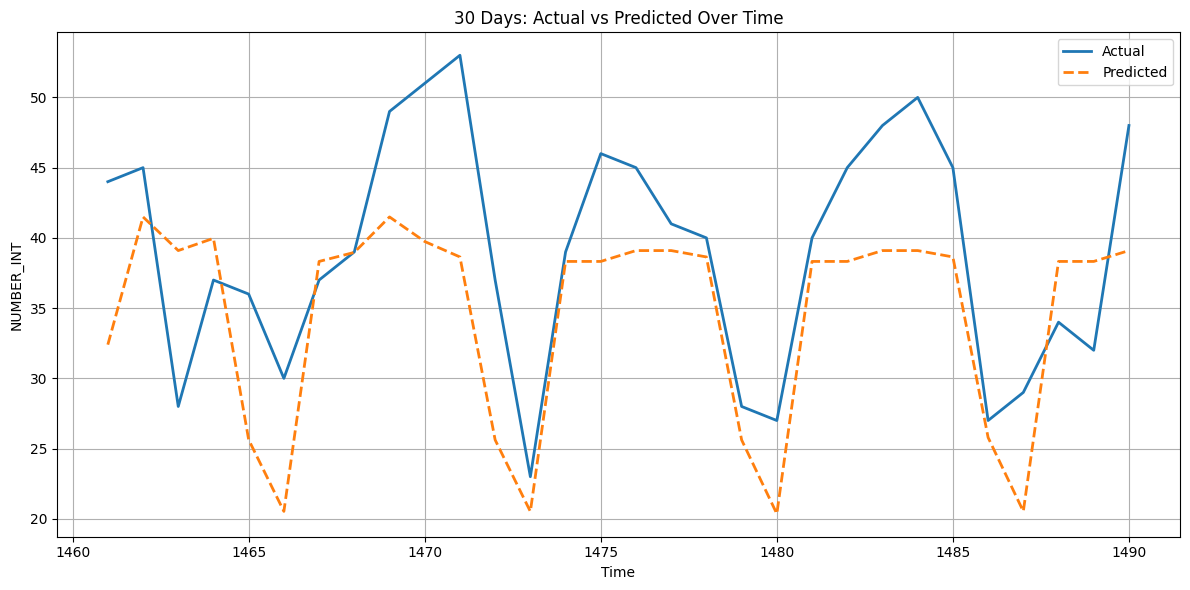

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index[:30], y_val[:30].values, label='Actual', linewidth=2)
plt.plot(y_val.index[:30], y_pred_best[:30], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title('30 Days: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

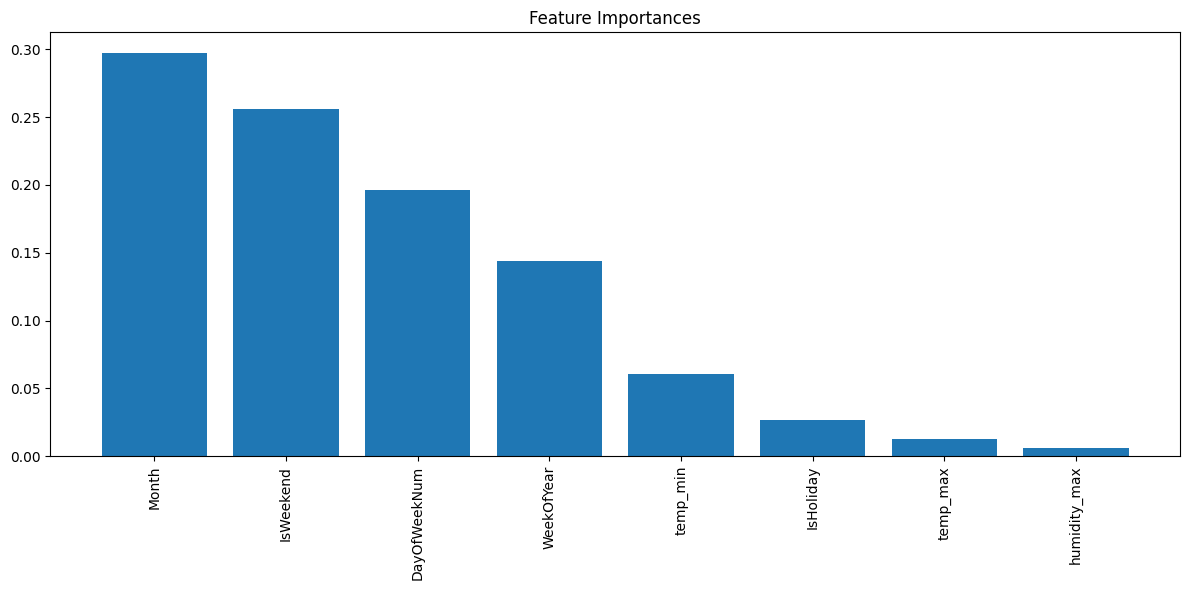

In [27]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()